# TTT4185 Machine learning for Speech technology

## Computer assigment 3b:  Regression analysis

Regression analysis is used to estimate/measure the relationship between an _independent_ variable, say $x$, and a _dependent_ variable, say $y$. One of the simplest regression problems is 
\begin{equation}
y = ax + b
\end{equation}
where $a$ and $b$ are constants. In practice our observations will be contaminated by noise, so we have
\begin{equation}
y = ax + b + n,
\end{equation}
where $n$ is noise, eg. measurement errors. This particular problem is called _linear regression_.

We will have a look at _non-linear regression_, using deep neural networks. Here we are looking at general regression problems in the form 
\begin{equation}
y = f(x) + n.
\end{equation}

We generate our data according to the function $f(x) = x^2 + \cos(20x) \text{ sign}(x)$, obtaining a set of observations $\{(x_i,y_i)\}$.

Then we assume we do not know the underlying function and we try to recover and approximation of $f$ only using the observations $\{(x_i,y_i)\}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

2021-11-08 13:50:06.740943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 13:50:06.740979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


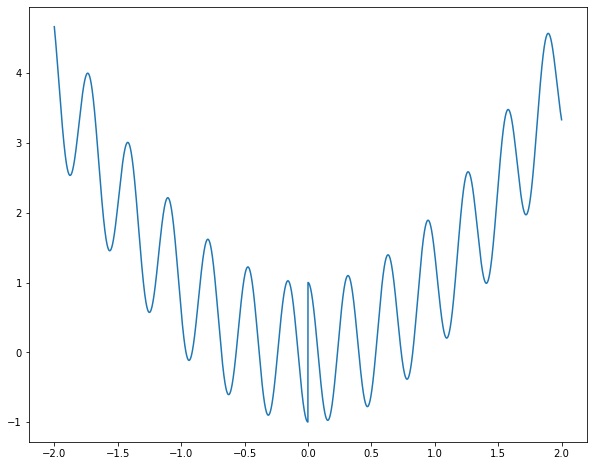

In [2]:
# Define function
def f(x):
    return x**2 + np.cos(20*x)*np.sign(x)

# Setup some simulation parameters
# Number of observations
N = 5000

# Plot a "clean" version of the relationship between x and y
plt.figure(figsize=(10, 8))
x = np.linspace(-2,2,N)
plt.plot(x,f(x))
plt.show()

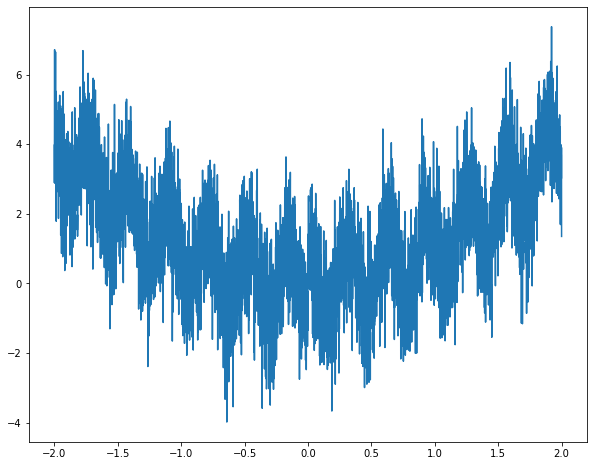

In [3]:
# Create a noise version of the observations
y = f(x) + np.random.randn(len(x))
plt.figure(figsize=(10, 8))
plt.plot(x,y)
plt.show()

One way to perform regression is to assume that the data is generated using a set of functions from a cerain family, for example polynomials of order $p$,
\begin{equation}
\hat f(x) = a_0 + a_1 x + a_2 x^2 \ldots a_p x^p.
\end{equation}
Then regression corresponds to fitting the parameters in the model. Let us see how this works out before using our neural networks.

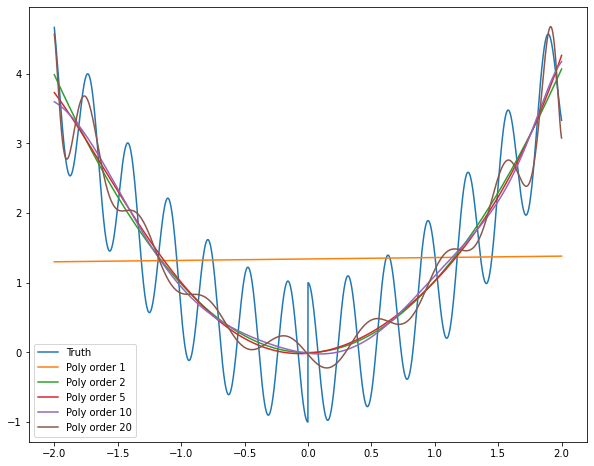

In [4]:
# Give a set of polynomial orders to try
P = [1, 2, 5, 10, 20]

# Define estimator function. Arguments are inout variable, observation and polynomial order
# Returns a set of polynomial coefficients
def reg_estimator(x,y,p):
    # Use simple ls approach
    N = len(x)
    H = np.zeros((N,p+1))
    for col in range(p+1):
        H[:,col] = x**col
    iHtH = np.linalg.inv(np.dot(H.T,H))
    theta = np.dot(np.dot(iHtH,H.T),y)
    return theta

# Computes fx) = c_0 + c_1x + c_2 x^2 ... c_p x^p
def poly(x, C):
    # compute p(x) for coeffs in c
    y = 0*x
    for p, c in enumerate(C):
        y += c*x**p        
    return y

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

## Problem 1
Play with different $p$ to see how close you can get to the true function.

Note: Very high $p$ will give numerical problems.

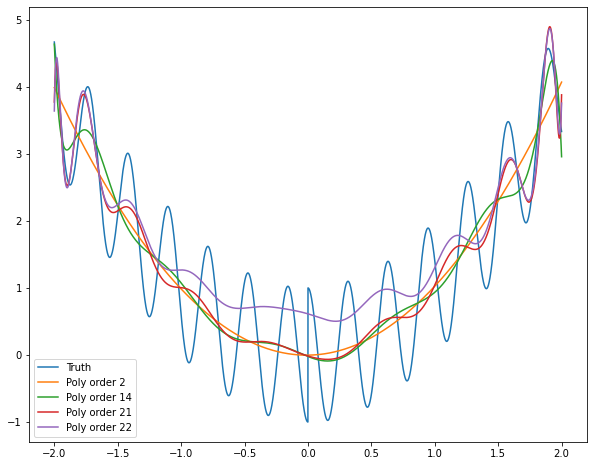

In [23]:
P = [2, 14, 21, 22]

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

Going with p > 21 seems to start to cause numerical problems. So 21 seems to be the closest fit. This only seems to fit well at [-2.0, -1.5] and [1.5, 2.0]. Inbetween the shape doesn't correspond to the actual function at all. The x^2 fit can be seen for all polynomials of order larger than 1. But the cosine part is missing.

In what follows we will use a deep neural network to approximate $f$. We set this up below

In [24]:
# Ceate a model with a single hidden layer. Note that input and output has
# dimension one
M = 512
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(1)
])

model.summary()
# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


2021-11-08 14:02:01.530591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-08 14:02:01.530623: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-08 14:02:01.530646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nb-x1-carbon): /proc/driver/nvidia/version does not exist
2021-11-08 14:02:01.530896: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We train the network by using $x$ as an input and the squared error between the network output $\hat y$ and the observed value $y$ as a loss
\begin{equation}
 L = \frac{1}{N} \sum_n (\hat y - y)^2
\end{equation}

We first try our network on clean data to check if it works.

In [25]:
# train the model
history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=True)

Epoch 1/1000
40/40 [==============================] - 1s 4ms/step - loss: 1.8381 - accuracy: 0.0000e+00
Epoch 2/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.8574 - accuracy: 0.0000e+00
Epoch 3/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.7135 - accuracy: 0.0000e+00
Epoch 4/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.6375 - accuracy: 0.0000e+00
Epoch 5/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.5899 - accuracy: 0.0000e+00
Epoch 6/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.5582 - accuracy: 0.0000e+00
Epoch 7/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.5432 - accuracy: 0.0000e+00
Epoch 8/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.5289 - accuracy: 0.0000e+00
Epoch 9/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.5209 - accuracy: 0.0000e+00
Epoch 10/1000
40/40 [==============================] - 0s 7ms/st

40/40 [==============================] - 0s 5ms/step - loss: 0.4911 - accuracy: 0.0000e+00
Epoch 80/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4897 - accuracy: 0.0000e+00
Epoch 81/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4909 - accuracy: 0.0000e+00
Epoch 82/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4901 - accuracy: 0.0000e+00
Epoch 83/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4921 - accuracy: 0.0000e+00
Epoch 84/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4895 - accuracy: 0.0000e+00
Epoch 85/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4909 - accuracy: 0.0000e+00
Epoch 86/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4920 - accuracy: 0.0000e+00
Epoch 87/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4918 - accuracy: 0.0000e+00
Epoch 88/1000
40/40 [==============================] - 0s 5ms/step - 

40/40 [==============================] - 0s 4ms/step - loss: 0.4869 - accuracy: 0.0000e+00
Epoch 157/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4860 - accuracy: 0.0000e+00
Epoch 158/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4866 - accuracy: 0.0000e+00
Epoch 159/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4867 - accuracy: 0.0000e+00
Epoch 160/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4865 - accuracy: 0.0000e+00
Epoch 161/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4852 - accuracy: 0.0000e+00
Epoch 162/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4874 - accuracy: 0.0000e+00
Epoch 163/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4856 - accuracy: 0.0000e+00
Epoch 164/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4858 - accuracy: 0.0000e+00
Epoch 165/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 6ms/step - loss: 0.4848 - accuracy: 0.0000e+00
Epoch 234/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4846 - accuracy: 0.0000e+00
Epoch 235/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4840 - accuracy: 0.0000e+00
Epoch 236/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4862 - accuracy: 0.0000e+00
Epoch 237/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4842 - accuracy: 0.0000e+00
Epoch 238/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4852 - accuracy: 0.0000e+00
Epoch 239/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4845 - accuracy: 0.0000e+00
Epoch 240/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4838 - accuracy: 0.0000e+00
Epoch 241/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4838 - accuracy: 0.0000e+00
Epoch 242/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 5ms/step - loss: 0.4816 - accuracy: 0.0000e+00
Epoch 311/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4818 - accuracy: 0.0000e+00
Epoch 312/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4815 - accuracy: 0.0000e+00
Epoch 313/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4841 - accuracy: 0.0000e+00
Epoch 314/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4843 - accuracy: 0.0000e+00
Epoch 315/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4834 - accuracy: 0.0000e+00
Epoch 316/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4809 - accuracy: 0.0000e+00
Epoch 317/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4831 - accuracy: 0.0000e+00
Epoch 318/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4820 - accuracy: 0.0000e+00
Epoch 319/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.4792 - accuracy: 0.0000e+00
Epoch 388/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4803 - accuracy: 0.0000e+00
Epoch 389/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4851 - accuracy: 0.0000e+00
Epoch 390/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4801 - accuracy: 0.0000e+00
Epoch 391/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4808 - accuracy: 0.0000e+00
Epoch 392/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4825 - accuracy: 0.0000e+00
Epoch 393/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4794 - accuracy: 0.0000e+00
Epoch 394/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4809 - accuracy: 0.0000e+00
Epoch 395/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4809 - accuracy: 0.0000e+00
Epoch 396/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 6ms/step - loss: 0.4793 - accuracy: 0.0000e+00
Epoch 464/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4780 - accuracy: 0.0000e+00
Epoch 465/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4795 - accuracy: 0.0000e+00
Epoch 466/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4790 - accuracy: 0.0000e+00
Epoch 467/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4789 - accuracy: 0.0000e+00
Epoch 468/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4795 - accuracy: 0.0000e+00
Epoch 469/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4784 - accuracy: 0.0000e+00
Epoch 470/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4800 - accuracy: 0.0000e+00
Epoch 471/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4775 - accuracy: 0.0000e+00
Epoch 472/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 6ms/step - loss: 0.4784 - accuracy: 0.0000e+00
Epoch 541/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4873 - accuracy: 0.0000e+00
Epoch 542/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 0.0000e+00
Epoch 543/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4770 - accuracy: 0.0000e+00
Epoch 544/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4782 - accuracy: 0.0000e+00
Epoch 545/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4777 - accuracy: 0.0000e+00
Epoch 546/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4779 - accuracy: 0.0000e+00
Epoch 547/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4788 - accuracy: 0.0000e+00
Epoch 548/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4775 - accuracy: 0.0000e+00: 0s - loss: 0.4734 - accuracy: 0.00
Epoch 549/1000
40/40 [===

40/40 [==============================] - 0s 7ms/step - loss: 0.4779 - accuracy: 0.0000e+00
Epoch 616/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4767 - accuracy: 0.0000e+00
Epoch 617/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4746 - accuracy: 0.0000e+00
Epoch 618/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4746 - accuracy: 0.0000e+00
Epoch 619/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4745 - accuracy: 0.0000e+00
Epoch 620/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.4754 - accuracy: 0.0000e+00
Epoch 621/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4739 - accuracy: 0.0000e+00
Epoch 622/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4783 - accuracy: 0.0000e+00
Epoch 623/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4759 - accuracy: 0.0000e+00
Epoch 624/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.4740 - accuracy: 0.0000e+00
Epoch 692/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.4710 - accuracy: 0.0000e+00
Epoch 693/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4732 - accuracy: 0.0000e+00
Epoch 694/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4751 - accuracy: 0.0000e+00
Epoch 695/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4712 - accuracy: 0.0000e+00
Epoch 696/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4711 - accuracy: 0.0000e+00
Epoch 697/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4718 - accuracy: 0.0000e+00
Epoch 698/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4717 - accuracy: 0.0000e+00
Epoch 699/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4772 - accuracy: 0.0000e+00
Epoch 700/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.4708 - accuracy: 0.0000e+00
Epoch 768/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.4723 - accuracy: 0.0000e+00
Epoch 769/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4686 - accuracy: 0.0000e+00
Epoch 770/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4717 - accuracy: 0.0000e+00
Epoch 771/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4696 - accuracy: 0.0000e+00
Epoch 772/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4695 - accuracy: 0.0000e+00
Epoch 773/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4737 - accuracy: 0.0000e+00
Epoch 774/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4682 - accuracy: 0.0000e+00
Epoch 775/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4678 - accuracy: 0.0000e+00
Epoch 776/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.0000e+00
Epoch 845/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.0000e+00
Epoch 846/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.0000e+00
Epoch 847/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4695 - accuracy: 0.0000e+00
Epoch 848/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.0000e+00
Epoch 849/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.0000e+00
Epoch 850/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4693 - accuracy: 0.0000e+00
Epoch 851/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.0000e+00
Epoch 852/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4738 - accuracy: 0.0000e+00
Epoch 853/1000
40/40 [==============================] - 0s 2m

40/40 [==============================] - 0s 2ms/step - loss: 0.4627 - accuracy: 0.0000e+00
Epoch 922/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4639 - accuracy: 0.0000e+00
Epoch 923/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.4696 - accuracy: 0.0000e+00
Epoch 924/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.0000e+00
Epoch 925/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.0000e+00
Epoch 926/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4649 - accuracy: 0.0000e+00
Epoch 927/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.0000e+00
Epoch 928/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4648 - accuracy: 0.0000e+00
Epoch 929/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.0000e+00
Epoch 930/1000
40/40 [==============================] - 0s 2m

40/40 [==============================] - 0s 2ms/step - loss: 0.4641 - accuracy: 0.0000e+00
Epoch 999/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.0000e+00
Epoch 1000/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.4628 - accuracy: 0.0000e+00


Using the variable `history`, plot the evolution of the loss during training. 

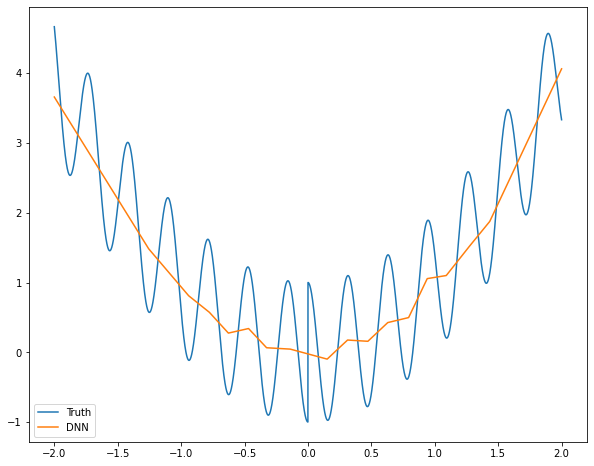

In [26]:
# Compute \hat y from the network and compare this to the true f(x)
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

## Problem 2
Try increasing the number of nodes in the network to see if the results can be improved.

In [36]:
# Ceate a model with a single hidden layer. Note that input and output has
# dimension one
M = 1024
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    #keras.layers.Dropout(0.5), will only result in fitting x^2 without cosine term
    keras.layers.Dense(1)
])

model.summary()
# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              2048      
                                                                 
 dense_9 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [37]:
# train the model
history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=True)

Epoch 1/1000
40/40 [==============================] - 1s 5ms/step - loss: 1.6850 - accuracy: 0.0000e+00
Epoch 2/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.7752 - accuracy: 0.0000e+00
Epoch 3/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.6442 - accuracy: 0.0000e+00
Epoch 4/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.5788 - accuracy: 0.0000e+00
Epoch 5/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.5422 - accuracy: 0.0000e+00
Epoch 6/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.5249 - accuracy: 0.0000e+00
Epoch 7/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.5165 - accuracy: 0.0000e+00
Epoch 8/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.5110 - accuracy: 0.0000e+00
Epoch 9/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.5087 - accuracy: 0.0000e+00
Epoch 10/1000
40/40 [==============================] - 0s 4ms/st

40/40 [==============================] - 0s 6ms/step - loss: 0.4890 - accuracy: 0.0000e+00
Epoch 79/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4886 - accuracy: 0.0000e+00
Epoch 80/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4868 - accuracy: 0.0000e+00
Epoch 81/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4877 - accuracy: 0.0000e+00
Epoch 82/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4909 - accuracy: 0.0000e+00
Epoch 83/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4886 - accuracy: 0.0000e+00
Epoch 84/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4871 - accuracy: 0.0000e+00
Epoch 85/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4886 - accuracy: 0.0000e+00
Epoch 86/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4966 - accuracy: 0.0000e+00
Epoch 87/1000
40/40 [==============================] - 0s 5ms/step - 

40/40 [==============================] - 0s 5ms/step - loss: 0.4856 - accuracy: 0.0000e+00
Epoch 156/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4843 - accuracy: 0.0000e+00
Epoch 157/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4843 - accuracy: 0.0000e+00
Epoch 158/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4860 - accuracy: 0.0000e+00
Epoch 159/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4852 - accuracy: 0.0000e+00
Epoch 160/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4858 - accuracy: 0.0000e+00
Epoch 161/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4856 - accuracy: 0.0000e+00
Epoch 162/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4865 - accuracy: 0.0000e+00
Epoch 163/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4831 - accuracy: 0.0000e+00
Epoch 164/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 5ms/step - loss: 0.4819 - accuracy: 0.0000e+00
Epoch 233/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4825 - accuracy: 0.0000e+00
Epoch 234/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4834 - accuracy: 0.0000e+00
Epoch 235/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4820 - accuracy: 0.0000e+00
Epoch 236/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4860 - accuracy: 0.0000e+00
Epoch 237/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4832 - accuracy: 0.0000e+00
Epoch 238/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4822 - accuracy: 0.0000e+00
Epoch 239/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4820 - accuracy: 0.0000e+00
Epoch 240/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4817 - accuracy: 0.0000e+00
Epoch 241/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.4838 - accuracy: 0.0000e+00
Epoch 310/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4801 - accuracy: 0.0000e+00
Epoch 311/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4797 - accuracy: 0.0000e+00
Epoch 312/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.4810 - accuracy: 0.0000e+00
Epoch 313/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4817 - accuracy: 0.0000e+00
Epoch 314/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4844 - accuracy: 0.0000e+00
Epoch 315/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4839 - accuracy: 0.0000e+00
Epoch 316/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4819 - accuracy: 0.0000e+00
Epoch 317/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4840 - accuracy: 0.0000e+00
Epoch 318/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.4794 - accuracy: 0.0000e+00
Epoch 387/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4800 - accuracy: 0.0000e+00
Epoch 388/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4801 - accuracy: 0.0000e+00
Epoch 389/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4794 - accuracy: 0.0000e+00
Epoch 390/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4802 - accuracy: 0.0000e+00
Epoch 391/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.4799 - accuracy: 0.0000e+00
Epoch 392/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4797 - accuracy: 0.0000e+00
Epoch 393/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4799 - accuracy: 0.0000e+00
Epoch 394/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4828 - accuracy: 0.0000e+00
Epoch 395/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 5ms/step - loss: 0.4826 - accuracy: 0.0000e+00
Epoch 464/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4757 - accuracy: 0.0000e+00
Epoch 465/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4765 - accuracy: 0.0000e+00
Epoch 466/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4777 - accuracy: 0.0000e+00
Epoch 467/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4785 - accuracy: 0.0000e+00
Epoch 468/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4769 - accuracy: 0.0000e+00
Epoch 469/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4779 - accuracy: 0.0000e+00
Epoch 470/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4761 - accuracy: 0.0000e+00
Epoch 471/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4775 - accuracy: 0.0000e+00
Epoch 472/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 7ms/step - loss: 0.4768 - accuracy: 0.0000e+00
Epoch 541/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4749 - accuracy: 0.0000e+00
Epoch 542/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.4743 - accuracy: 0.0000e+00
Epoch 543/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4753 - accuracy: 0.0000e+00
Epoch 544/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.4743 - accuracy: 0.0000e+00
Epoch 545/1000
40/40 [==============================] - 0s 11ms/step - loss: 0.4745 - accuracy: 0.0000e+00
Epoch 546/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.4746 - accuracy: 0.0000e+00
Epoch 547/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.4724 - accuracy: 0.0000e+00
Epoch 548/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4731 - accuracy: 0.0000e+00
Epoch 549/1000
40/40 [==============================] - 0s 

40/40 [==============================] - 0s 6ms/step - loss: 0.4730 - accuracy: 0.0000e+00
Epoch 618/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4724 - accuracy: 0.0000e+00
Epoch 619/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4716 - accuracy: 0.0000e+00
Epoch 620/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4710 - accuracy: 0.0000e+00
Epoch 621/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4718 - accuracy: 0.0000e+00
Epoch 622/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4722 - accuracy: 0.0000e+00
Epoch 623/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4704 - accuracy: 0.0000e+00
Epoch 624/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4701 - accuracy: 0.0000e+00
Epoch 625/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4751 - accuracy: 0.0000e+00
Epoch 626/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.4691 - accuracy: 0.0000e+00
Epoch 695/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4687 - accuracy: 0.0000e+00
Epoch 696/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4725 - accuracy: 0.0000e+00
Epoch 697/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4700 - accuracy: 0.0000e+00
Epoch 698/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4684 - accuracy: 0.0000e+00
Epoch 699/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4704 - accuracy: 0.0000e+00
Epoch 700/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4731 - accuracy: 0.0000e+00
Epoch 701/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4689 - accuracy: 0.0000e+00
Epoch 702/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4837 - accuracy: 0.0000e+00
Epoch 703/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 6ms/step - loss: 0.4661 - accuracy: 0.0000e+00
Epoch 771/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4709 - accuracy: 0.0000e+00
Epoch 772/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4663 - accuracy: 0.0000e+00
Epoch 773/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4683 - accuracy: 0.0000e+00
Epoch 774/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4680 - accuracy: 0.0000e+00
Epoch 775/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4724 - accuracy: 0.0000e+00
Epoch 776/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4677 - accuracy: 0.0000e+00
Epoch 777/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4656 - accuracy: 0.0000e+00
Epoch 778/1000
40/40 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.0000e+ - 0s 5ms/step - loss: 0.4664 - accuracy: 0.0000e+00
Epoch 779/1000


40/40 [==============================] - 0s 6ms/step - loss: 0.4645 - accuracy: 0.0000e+00
Epoch 847/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4622 - accuracy: 0.0000e+00
Epoch 848/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4657 - accuracy: 0.0000e+00
Epoch 849/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4608 - accuracy: 0.0000e+00
Epoch 850/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4637 - accuracy: 0.0000e+00
Epoch 851/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4640 - accuracy: 0.0000e+00
Epoch 852/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.4664 - accuracy: 0.0000e+00
Epoch 853/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4676 - accuracy: 0.0000e+00
Epoch 854/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4674 - accuracy: 0.0000e+00
Epoch 855/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.0000e+00
Epoch 923/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4618 - accuracy: 0.0000e+00
Epoch 924/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4601 - accuracy: 0.0000e+00
Epoch 925/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4600 - accuracy: 0.0000e+00
Epoch 926/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4579 - accuracy: 0.0000e+00
Epoch 927/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.4615 - accuracy: 0.0000e+00
Epoch 928/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4613 - accuracy: 0.0000e+00
Epoch 929/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4604 - accuracy: 0.0000e+00
Epoch 930/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4584 - accuracy: 0.0000e+00
Epoch 931/1000
40/40 [==============================] - 0s 7m

40/40 [==============================] - 0s 7ms/step - loss: 0.4789 - accuracy: 0.0000e+00
Epoch 1000/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4572 - accuracy: 0.0000e+00


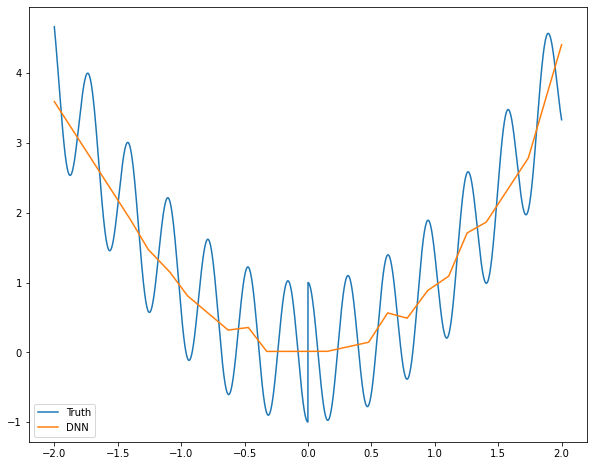

In [38]:
# Compute \hat y from the network and compare this to the true f(x)
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

Next we will use a deep network with more than one hidden layer.

In [41]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 16
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                32        
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================] - 1s

40/40 [==============================] - 0s 5ms/step - loss: 0.4575 - accuracy: 0.0000e+00
Epoch 69/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.4548 - accuracy: 0.0000e+00
Epoch 70/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4554 - accuracy: 0.0000e+00
Epoch 71/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.4601 - accuracy: 0.0000e+00
Epoch 72/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.0000e+00
Epoch 73/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.0000e+00
Epoch 74/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4564 - accuracy: 0.0000e+00
Epoch 75/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4549 - accuracy: 0.0000e+00
Epoch 76/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.4561 - accuracy: 0.0000e+00
Epoch 77/1000
40/40 [==============================] - 0s 4ms/step - 

40/40 [==============================] - 0s 3ms/step - loss: 0.4042 - accuracy: 0.0000e+00
Epoch 146/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4049 - accuracy: 0.0000e+00
Epoch 147/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.4039 - accuracy: 0.0000e+00
Epoch 148/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4006 - accuracy: 0.0000e+00
Epoch 149/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4066 - accuracy: 0.0000e+00
Epoch 150/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4016 - accuracy: 0.0000e+00
Epoch 151/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.4038 - accuracy: 0.0000e+00
Epoch 152/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3979 - accuracy: 0.0000e+00
Epoch 153/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3981 - accuracy: 0.0000e+00
Epoch 154/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 6ms/step - loss: 0.3788 - accuracy: 0.0000e+00
Epoch 223/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.0000e+00
Epoch 224/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3718 - accuracy: 0.0000e+00
Epoch 225/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3692 - accuracy: 0.0000e+00
Epoch 226/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3714 - accuracy: 0.0000e+00
Epoch 227/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.0000e+00
Epoch 228/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3772 - accuracy: 0.0000e+00
Epoch 229/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3736 - accuracy: 0.0000e+00: 0s - loss: 0.3747 - accuracy: 0.0000
Epoch 230/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3744 - accuracy: 0.0000e+00
Epoch 231/1000
40/40 [=

40/40 [==============================] - 0s 4ms/step - loss: 0.3623 - accuracy: 0.0000e+00
Epoch 300/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3664 - accuracy: 0.0000e+00
Epoch 301/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3599 - accuracy: 0.0000e+00
Epoch 302/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3657 - accuracy: 0.0000e+00
Epoch 303/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3630 - accuracy: 0.0000e+00
Epoch 304/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3590 - accuracy: 0.0000e+00
Epoch 305/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3583 - accuracy: 0.0000e+00
Epoch 306/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3573 - accuracy: 0.0000e+00
Epoch 307/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3621 - accuracy: 0.0000e+00
Epoch 308/1000
40/40 [==============================] - 0s 5m

Epoch 376/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3499 - accuracy: 0.0000e+00
Epoch 377/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3459 - accuracy: 0.0000e+00
Epoch 378/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3502 - accuracy: 0.0000e+00
Epoch 379/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3557 - accuracy: 0.0000e+00
Epoch 380/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3495 - accuracy: 0.0000e+00
Epoch 381/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3476 - accuracy: 0.0000e+00
Epoch 382/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3496 - accuracy: 0.0000e+00
Epoch 383/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3473 - accuracy: 0.0000e+00
Epoch 384/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3468 - accuracy: 0.0000e+00
Epoch 385/1000
40/40 [========================

40/40 [==============================] - 0s 4ms/step - loss: 0.3487 - accuracy: 0.0000e+00
Epoch 453/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3443 - accuracy: 0.0000e+00
Epoch 454/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3423 - accuracy: 0.0000e+00
Epoch 455/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3468 - accuracy: 0.0000e+00
Epoch 456/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3437 - accuracy: 0.0000e+00
Epoch 457/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3485 - accuracy: 0.0000e+00
Epoch 458/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3504 - accuracy: 0.0000e+00
Epoch 459/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3454 - accuracy: 0.0000e+00
Epoch 460/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3551 - accuracy: 0.0000e+00
Epoch 461/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 5ms/step - loss: 0.3463 - accuracy: 0.0000e+00
Epoch 530/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3452 - accuracy: 0.0000e+00
Epoch 531/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3412 - accuracy: 0.0000e+00
Epoch 532/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3473 - accuracy: 0.0000e+00
Epoch 533/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3426 - accuracy: 0.0000e+00
Epoch 534/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3434 - accuracy: 0.0000e+00
Epoch 535/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3510 - accuracy: 0.0000e+00
Epoch 536/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3441 - accuracy: 0.0000e+00
Epoch 537/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3424 - accuracy: 0.0000e+00
Epoch 538/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 3ms/step - loss: 0.3452 - accuracy: 0.0000e+00
Epoch 607/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3433 - accuracy: 0.0000e+00
Epoch 608/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3469 - accuracy: 0.0000e+00
Epoch 609/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3450 - accuracy: 0.0000e+00
Epoch 610/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3447 - accuracy: 0.0000e+00
Epoch 611/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3463 - accuracy: 0.0000e+00
Epoch 612/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3420 - accuracy: 0.0000e+00
Epoch 613/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3436 - accuracy: 0.0000e+00
Epoch 614/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3468 - accuracy: 0.0000e+00
Epoch 615/1000
40/40 [==============================] - 0s 4m

Epoch 683/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3467 - accuracy: 0.0000e+00
Epoch 684/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3460 - accuracy: 0.0000e+00
Epoch 685/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3468 - accuracy: 0.0000e+00
Epoch 686/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3428 - accuracy: 0.0000e+00
Epoch 687/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3476 - accuracy: 0.0000e+00
Epoch 688/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3442 - accuracy: 0.0000e+00
Epoch 689/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3448 - accuracy: 0.0000e+00
Epoch 690/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3489 - accuracy: 0.0000e+00
Epoch 691/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3424 - accuracy: 0.0000e+00
Epoch 692/1000
40/40 [========================

40/40 [==============================] - 0s 5ms/step - loss: 0.3528 - accuracy: 0.0000e+00
Epoch 760/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3413 - accuracy: 0.0000e+00
Epoch 761/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3435 - accuracy: 0.0000e+00
Epoch 762/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3410 - accuracy: 0.0000e+00
Epoch 763/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3444 - accuracy: 0.0000e+00
Epoch 764/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3480 - accuracy: 0.0000e+00
Epoch 765/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3448 - accuracy: 0.0000e+00
Epoch 766/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3451 - accuracy: 0.0000e+00
Epoch 767/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3389 - accuracy: 0.0000e+00
Epoch 768/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.3392 - accuracy: 0.0000e+00
Epoch 837/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3437 - accuracy: 0.0000e+00
Epoch 838/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3433 - accuracy: 0.0000e+00
Epoch 839/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3429 - accuracy: 0.0000e+00
Epoch 840/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.3382 - accuracy: 0.0000e+00: 0s - loss: 0.3429 - accuracy: 0.00
Epoch 841/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3411 - accuracy: 0.0000e+00
Epoch 842/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3397 - accuracy: 0.0000e+00
Epoch 843/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3391 - accuracy: 0.0000e+00: 0s - loss: 0.3420 - accuracy: 0.00
Epoch 844/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3402 - accuracy: 

40/40 [==============================] - 0s 4ms/step - loss: 0.3440 - accuracy: 0.0000e+00
Epoch 913/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3394 - accuracy: 0.0000e+00
Epoch 914/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3385 - accuracy: 0.0000e+00
Epoch 915/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3382 - accuracy: 0.0000e+00
Epoch 916/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3373 - accuracy: 0.0000e+00
Epoch 917/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3403 - accuracy: 0.0000e+00
Epoch 918/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3426 - accuracy: 0.0000e+00
Epoch 919/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3422 - accuracy: 0.0000e+00
Epoch 920/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3409 - accuracy: 0.0000e+00
Epoch 921/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 6ms/step - loss: 0.3401 - accuracy: 0.0000e+00
Epoch 990/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3383 - accuracy: 0.0000e+00
Epoch 991/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3435 - accuracy: 0.0000e+00
Epoch 992/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3397 - accuracy: 0.0000e+00
Epoch 993/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3446 - accuracy: 0.0000e+00
Epoch 994/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3414 - accuracy: 0.0000e+00
Epoch 995/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3406 - accuracy: 0.0000e+00
Epoch 996/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3391 - accuracy: 0.0000e+00
Epoch 997/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3413 - accuracy: 0.0000e+00
Epoch 998/1000
40/40 [==============================] - 0s 5m

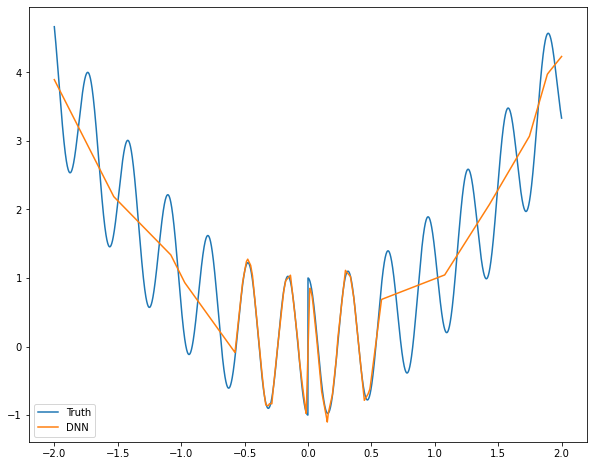

In [42]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

## Problem 3
Try increasing the number of hidden nodes per layer until performance is satisfactory. Can the same effect be achieved by just adding more layers?

### 32 Nodes per Layer

In [43]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 32
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                64        
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 32)                1056      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================] 

40/40 [==============================] - 0s 4ms/step - loss: 0.4059 - accuracy: 0.0000e+00
Epoch 69/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3987 - accuracy: 0.0000e+00
Epoch 70/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3907 - accuracy: 0.0000e+00
Epoch 71/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3877 - accuracy: 0.0000e+00
Epoch 72/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3873 - accuracy: 0.0000e+00
Epoch 73/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3900 - accuracy: 0.0000e+00
Epoch 74/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3858 - accuracy: 0.0000e+00
Epoch 75/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3857 - accuracy: 0.0000e+00
Epoch 76/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3812 - accuracy: 0.0000e+00
Epoch 77/1000
40/40 [==============================] - 0s 6ms/step - 

40/40 [==============================] - 0s 5ms/step - loss: 0.3278 - accuracy: 0.0000e+00
Epoch 146/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3278 - accuracy: 0.0000e+00
Epoch 147/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3336 - accuracy: 0.0000e+00
Epoch 148/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3250 - accuracy: 0.0000e+00
Epoch 149/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3234 - accuracy: 0.0000e+00
Epoch 150/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.3243 - accuracy: 0.0000e+00
Epoch 151/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3231 - accuracy: 0.0000e+00
Epoch 152/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3314 - accuracy: 0.0000e+00
Epoch 153/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3228 - accuracy: 0.0000e+00
Epoch 154/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 4ms/step - loss: 0.2846 - accuracy: 0.0000e+00
Epoch 223/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2845 - accuracy: 0.0000e+00
Epoch 224/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2922 - accuracy: 0.0000e+00
Epoch 225/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2810 - accuracy: 0.0000e+00
Epoch 226/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2858 - accuracy: 0.0000e+00
Epoch 227/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2915 - accuracy: 0.0000e+00
Epoch 228/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2815 - accuracy: 0.0000e+00
Epoch 229/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2821 - accuracy: 0.0000e+00
Epoch 230/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2823 - accuracy: 0.0000e+00
Epoch 231/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 8ms/step - loss: 0.2538 - accuracy: 0.0000e+00
Epoch 299/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2554 - accuracy: 0.0000e+00
Epoch 300/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2587 - accuracy: 0.0000e+00
Epoch 301/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2683 - accuracy: 0.0000e+00
Epoch 302/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2508 - accuracy: 0.0000e+00
Epoch 303/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2514 - accuracy: 0.0000e+00
Epoch 304/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2568 - accuracy: 0.0000e+00
Epoch 305/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2475 - accuracy: 0.0000e+00
Epoch 306/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.2521 - accuracy: 0.0000e+00
Epoch 307/1000
40/40 [==============================] - 0s 4m

Epoch 375/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2368 - accuracy: 0.0000e+00
Epoch 376/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2468 - accuracy: 0.0000e+00
Epoch 377/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2421 - accuracy: 0.0000e+00
Epoch 378/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2339 - accuracy: 0.0000e+00
Epoch 379/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2381 - accuracy: 0.0000e+00
Epoch 380/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2391 - accuracy: 0.0000e+00
Epoch 381/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2343 - accuracy: 0.0000e+00
Epoch 382/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2477 - accuracy: 0.0000e+00
Epoch 383/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2392 - accuracy: 0.0000e+00
Epoch 384/1000
40/40 [========================

40/40 [==============================] - 0s 5ms/step - loss: 0.2229 - accuracy: 0.0000e+00
Epoch 452/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2312 - accuracy: 0.0000e+00
Epoch 453/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2281 - accuracy: 0.0000e+00
Epoch 454/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2319 - accuracy: 0.0000e+00
Epoch 455/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2176 - accuracy: 0.0000e+00
Epoch 456/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2245 - accuracy: 0.0000e+00
Epoch 457/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2207 - accuracy: 0.0000e+00
Epoch 458/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2258 - accuracy: 0.0000e+00: 0s - loss: 0.2184 - accuracy: 0.
Epoch 459/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2272 - accuracy: 0.0000e+00
Epoch 460/1000
40/40 [=====

40/40 [==============================] - 0s 4ms/step - loss: 0.2134 - accuracy: 0.0000e+00
Epoch 528/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2086 - accuracy: 0.0000e+00
Epoch 529/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2112 - accuracy: 0.0000e+00
Epoch 530/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.2072 - accuracy: 0.0000e+00
Epoch 531/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2239 - accuracy: 0.0000e+00
Epoch 532/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2165 - accuracy: 0.0000e+00
Epoch 533/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.2115 - accuracy: 0.0000e+00
Epoch 534/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2098 - accuracy: 0.0000e+00
Epoch 535/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2000 - accuracy: 0.0000e+00
Epoch 536/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.0000e+00
Epoch 605/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1619 - accuracy: 0.0000e+00
Epoch 606/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1601 - accuracy: 0.0000e+00
Epoch 607/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1583 - accuracy: 0.0000e+00
Epoch 608/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1626 - accuracy: 0.0000e+00
Epoch 609/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1877 - accuracy: 0.0000e+00
Epoch 610/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1640 - accuracy: 0.0000e+00
Epoch 611/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1552 - accuracy: 0.0000e+00
Epoch 612/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1568 - accuracy: 0.0000e+00
Epoch 613/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 3ms/step - loss: 0.1280 - accuracy: 0.0000e+00
Epoch 682/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.0000e+00
Epoch 683/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1309 - accuracy: 0.0000e+00
Epoch 684/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1333 - accuracy: 0.0000e+00
Epoch 685/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1342 - accuracy: 0.0000e+00
Epoch 686/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.1358 - accuracy: 0.0000e+00
Epoch 687/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1385 - accuracy: 0.0000e+00
Epoch 688/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1274 - accuracy: 0.0000e+00
Epoch 689/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1303 - accuracy: 0.0000e+00
Epoch 690/1000
40/40 [==============================] - 0s 4m

Epoch 758/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1205 - accuracy: 0.0000e+00
Epoch 759/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1315 - accuracy: 0.0000e+00
Epoch 760/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1143 - accuracy: 0.0000e+00
Epoch 761/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1147 - accuracy: 0.0000e+00
Epoch 762/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1189 - accuracy: 0.0000e+00
Epoch 763/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1281 - accuracy: 0.0000e+00
Epoch 764/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1128 - accuracy: 0.0000e+00
Epoch 765/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1137 - accuracy: 0.0000e+00
Epoch 766/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1303 - accuracy: 0.0000e+00
Epoch 767/1000
40/40 [========================

40/40 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.0000e+00
Epoch 836/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1030 - accuracy: 0.0000e+00
Epoch 837/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0934 - accuracy: 0.0000e+00
Epoch 838/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0956 - accuracy: 0.0000e+00
Epoch 839/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.0000e+00
Epoch 840/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1041 - accuracy: 0.0000e+00
Epoch 841/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.0000e+00
Epoch 842/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0976 - accuracy: 0.0000e+00
Epoch 843/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0934 - accuracy: 0.0000e+00
Epoch 844/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 5ms/step - loss: 0.0827 - accuracy: 0.0000e+00
Epoch 913/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0880 - accuracy: 0.0000e+00
Epoch 914/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.0000e+00
Epoch 915/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0823 - accuracy: 0.0000e+00
Epoch 916/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.0000e+00
Epoch 917/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0828 - accuracy: 0.0000e+00: 0s - loss: 0.0904 - accuracy: 0.0000
Epoch 918/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0892 - accuracy: 0.0000e+00
Epoch 919/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0920 - accuracy: 0.0000e+00
Epoch 920/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0799 - accuracy: 0.0000e+00
Epoch 921/1000
40/40 [=

40/40 [==============================] - 0s 4ms/step - loss: 0.0883 - accuracy: 0.0000e+00
Epoch 989/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1314 - accuracy: 0.0000e+00
Epoch 990/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0755 - accuracy: 0.0000e+00
Epoch 991/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1482 - accuracy: 0.0000e+00
Epoch 992/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0765 - accuracy: 0.0000e+00
Epoch 993/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 994/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0772 - accuracy: 0.0000e+00
Epoch 995/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.0000e+00
Epoch 996/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0746 - accuracy: 0.0000e+00
Epoch 997/1000
40/40 [==============================] - 0s 4m

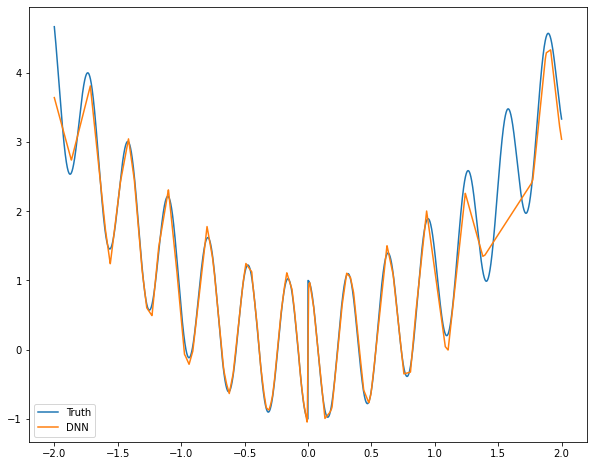

In [44]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

### 64 Nodes per Layer

In [45]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 64
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                128       
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================

40/40 [==============================] - 0s 5ms/step - loss: 0.3040 - accuracy: 0.0000e+00
Epoch 69/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3044 - accuracy: 0.0000e+00
Epoch 70/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3033 - accuracy: 0.0000e+00
Epoch 71/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2965 - accuracy: 0.0000e+00
Epoch 72/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.3018 - accuracy: 0.0000e+00
Epoch 73/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.3015 - accuracy: 0.0000e+00
Epoch 74/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2956 - accuracy: 0.0000e+00
Epoch 75/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2949 - accuracy: 0.0000e+00
Epoch 76/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2985 - accuracy: 0.0000e+00
Epoch 77/1000
40/40 [==============================] - 0s 5ms/step - 

40/40 [==============================] - 0s 5ms/step - loss: 0.1939 - accuracy: 0.0000e+00
Epoch 146/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1949 - accuracy: 0.0000e+00
Epoch 147/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1993 - accuracy: 0.0000e+00
Epoch 148/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1920 - accuracy: 0.0000e+00
Epoch 149/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1898 - accuracy: 0.0000e+00
Epoch 150/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1877 - accuracy: 0.0000e+00
Epoch 151/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1895 - accuracy: 0.0000e+00
Epoch 152/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1849 - accuracy: 0.0000e+00
Epoch 153/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1835 - accuracy: 0.0000e+00
Epoch 154/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.0000e+00
Epoch 223/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1160 - accuracy: 0.0000e+00
Epoch 224/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1146 - accuracy: 0.0000e+00
Epoch 225/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1183 - accuracy: 0.0000e+00
Epoch 226/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1230 - accuracy: 0.0000e+00
Epoch 227/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1159 - accuracy: 0.0000e+00
Epoch 228/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.0000e+00
Epoch 229/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.0000e+00
Epoch 230/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1103 - accuracy: 0.0000e+00
Epoch 231/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.0806 - accuracy: 0.0000e+00
Epoch 300/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0748 - accuracy: 0.0000e+00
Epoch 301/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.0000e+00
Epoch 302/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0777 - accuracy: 0.0000e+00
Epoch 303/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0766 - accuracy: 0.0000e+00
Epoch 304/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0729 - accuracy: 0.0000e+00
Epoch 305/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0728 - accuracy: 0.0000e+00
Epoch 306/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 307/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0688 - accuracy: 0.0000e+00
Epoch 308/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.0081 - accuracy: 0.0000e+00
Epoch 377/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0274 - accuracy: 0.0000e+00
Epoch 378/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0171 - accuracy: 0.0000e+00
Epoch 379/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0089 - accuracy: 0.0000e+00
Epoch 380/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0079 - accuracy: 0.0000e+00
Epoch 381/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0071 - accuracy: 0.0000e+00
Epoch 382/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0070 - accuracy: 0.0000e+00
Epoch 383/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0065 - accuracy: 0.0000e+00
Epoch 384/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0058 - accuracy: 0.0000e+00
Epoch 385/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 6ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 453/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0078 - accuracy: 0.0000e+00
Epoch 454/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0065 - accuracy: 0.0000e+00
Epoch 455/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 456/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 457/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 458/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 459/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0046 - accuracy: 0.0000e+00
Epoch 460/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0060 - accuracy: 0.0000e+00
Epoch 461/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 7ms/step - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 530/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 531/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 532/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.0000e+00
Epoch 533/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 0.0000e+00
Epoch 534/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 535/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.0000e+00
Epoch 536/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0046 - accuracy: 0.0000e+00
Epoch 537/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.0054 - accuracy: 0.0000e+00
Epoch 538/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 607/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 608/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0045 - accuracy: 0.0000e+00
Epoch 609/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0064 - accuracy: 0.0000e+00
Epoch 610/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 611/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 612/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 613/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 614/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 615/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 6ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 684/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 685/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 686/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 687/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 688/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 689/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 690/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.0000e+00
Epoch 691/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 692/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 7ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 761/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 762/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 763/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 764/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 765/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0040 - accuracy: 0.0000e+00
Epoch 766/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 767/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 768/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0074 - accuracy: 0.0000e+00
Epoch 769/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 838/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.0000e+00
Epoch 839/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0037 - accuracy: 0.0000e+00
Epoch 840/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 841/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 842/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 843/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 844/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 845/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.0000e+00
Epoch 846/1000
40/40 [==============================] - 0s 8m

40/40 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 915/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 916/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.0000e+00
Epoch 917/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.0000e+00
Epoch 918/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 919/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 920/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 921/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 922/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 923/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.0000e+00
Epoch 992/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 993/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 994/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 995/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch 996/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 0.0000e+00
Epoch 997/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 998/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 999/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 1000/1000
40/40 [==============================] - 0s 8

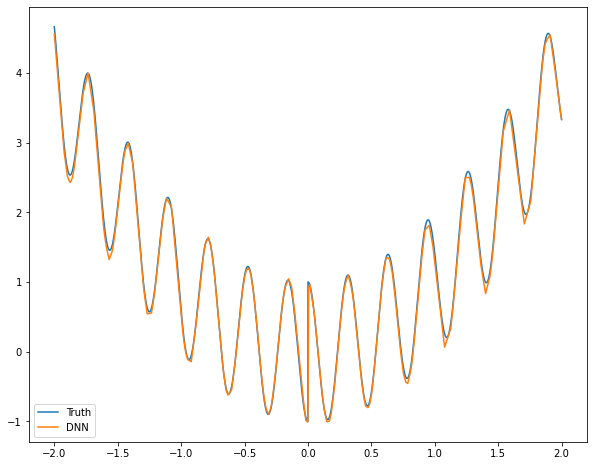

In [46]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

### Double the amount of Layers with 16 Nodes

In [47]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 16
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 16)                32        
                                                                 
 dense_31 (Dense)            (None, 16)                272       
                                                                 
 dense_32 (Dense)            (None, 16)                272       
                                                                 
 dense_33 (Dense)            (None, 16)                272       
                                                                 
 dense_34 (Dense)            (None, 16)                272       
                                                                 
 dense_35 (Dense)            (None, 16)                272       
                                                                 
 dense_36 (Dense)            (None, 16)               

40/40 [==============================] - 0s 6ms/step - loss: 0.2757 - accuracy: 0.0000e+00
Epoch 64/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2750 - accuracy: 0.0000e+00
Epoch 65/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2666 - accuracy: 0.0000e+00
Epoch 66/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2660 - accuracy: 0.0000e+00
Epoch 67/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2694 - accuracy: 0.0000e+00
Epoch 68/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2657 - accuracy: 0.0000e+00
Epoch 69/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.2622 - accuracy: 0.0000e+00
Epoch 70/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2659 - accuracy: 0.0000e+00
Epoch 71/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2643 - accuracy: 0.0000e+00
Epoch 72/1000
40/40 [==============================] - 0s 4ms/step - 

40/40 [==============================] - 0s 4ms/step - loss: 0.2494 - accuracy: 0.0000e+00
Epoch 141/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2494 - accuracy: 0.0000e+00
Epoch 142/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2423 - accuracy: 0.0000e+00
Epoch 143/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2423 - accuracy: 0.0000e+00
Epoch 144/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2427 - accuracy: 0.0000e+00
Epoch 145/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.2419 - accuracy: 0.0000e+00
Epoch 146/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.2397 - accuracy: 0.0000e+00
Epoch 147/1000
40/40 [==============================] - 0s 11ms/step - loss: 0.2412 - accuracy: 0.0000e+00
Epoch 148/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.2383 - accuracy: 0.0000e+00
Epoch 149/1000
40/40 [==============================] - 0s 6

40/40 [==============================] - 0s 4ms/step - loss: 0.1681 - accuracy: 0.0000e+00
Epoch 217/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1682 - accuracy: 0.0000e+00
Epoch 218/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1686 - accuracy: 0.0000e+00
Epoch 219/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1719 - accuracy: 0.0000e+00
Epoch 220/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1646 - accuracy: 0.0000e+00
Epoch 221/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1683 - accuracy: 0.0000e+00
Epoch 222/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1641 - accuracy: 0.0000e+00
Epoch 223/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1621 - accuracy: 0.0000e+00
Epoch 224/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1628 - accuracy: 0.0000e+00
Epoch 225/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 5ms/step - loss: 0.0923 - accuracy: 0.0000e+00
Epoch 294/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 0.0000e+00
Epoch 295/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0947 - accuracy: 0.0000e+00
Epoch 296/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0920 - accuracy: 0.0000e+00
Epoch 297/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0873 - accuracy: 0.0000e+00
Epoch 298/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0942 - accuracy: 0.0000e+00
Epoch 299/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1112 - accuracy: 0.0000e+00
Epoch 300/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.0000e+00
Epoch 301/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0880 - accuracy: 0.0000e+00
Epoch 302/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.0000e+00
Epoch 371/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0737 - accuracy: 0.0000e+00
Epoch 372/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 373/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0736 - accuracy: 0.0000e+00
Epoch 374/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0708 - accuracy: 0.0000e+00
Epoch 375/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0743 - accuracy: 0.0000e+00
Epoch 376/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.0000e+00
Epoch 377/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.0000e+00
Epoch 378/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0763 - accuracy: 0.0000e+00
Epoch 379/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 6ms/step - loss: 0.0543 - accuracy: 0.0000e+00
Epoch 448/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0517 - accuracy: 0.0000e+00
Epoch 449/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0472 - accuracy: 0.0000e+00
Epoch 450/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0465 - accuracy: 0.0000e+00
Epoch 451/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0471 - accuracy: 0.0000e+00
Epoch 452/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0511 - accuracy: 0.0000e+00
Epoch 453/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0428 - accuracy: 0.0000e+00
Epoch 454/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0418 - accuracy: 0.0000e+00
Epoch 455/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0401 - accuracy: 0.0000e+00
Epoch 456/1000
40/40 [==============================] - 0s 5m

40/40 [==============================] - 0s 5ms/step - loss: 0.0189 - accuracy: 0.0000e+00
Epoch 525/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0235 - accuracy: 0.0000e+00
Epoch 526/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0160 - accuracy: 0.0000e+00
Epoch 527/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0164 - accuracy: 0.0000e+00
Epoch 528/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0145 - accuracy: 0.0000e+00
Epoch 529/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0322 - accuracy: 0.0000e+00
Epoch 530/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0198 - accuracy: 0.0000e+00
Epoch 531/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0183 - accuracy: 0.0000e+00
Epoch 532/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0180 - accuracy: 0.0000e+00
Epoch 533/1000
40/40 [==============================] - 0s 4m

Epoch 601/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0132 - accuracy: 0.0000e+00
Epoch 602/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0158 - accuracy: 0.0000e+00
Epoch 603/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0121 - accuracy: 0.0000e+00
Epoch 604/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0124 - accuracy: 0.0000e+00
Epoch 605/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0145 - accuracy: 0.0000e+00
Epoch 606/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0109 - accuracy: 0.0000e+00
Epoch 607/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0121 - accuracy: 0.0000e+00
Epoch 608/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 609/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0122 - accuracy: 0.0000e+00
Epoch 610/1000
40/40 [========================

40/40 [==============================] - 0s 4ms/step - loss: 0.0070 - accuracy: 0.0000e+00
Epoch 679/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0077 - accuracy: 0.0000e+00
Epoch 680/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.0000e+00
Epoch 681/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0070 - accuracy: 0.0000e+00
Epoch 682/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.0000e+00
Epoch 683/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0086 - accuracy: 0.0000e+00
Epoch 684/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 0.0000e+00
Epoch 685/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0079 - accuracy: 0.0000e+00
Epoch 686/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0057 - accuracy: 0.0000e+00
Epoch 687/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 756/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0040 - accuracy: 0.0000e+00
Epoch 757/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.0058 - accuracy: 0.0000e+00
Epoch 758/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.0062 - accuracy: 0.0000e+00
Epoch 759/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.0082 - accuracy: 0.0000e+00
Epoch 760/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.0078 - accuracy: 0.0000e+00
Epoch 761/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0055 - accuracy: 0.0000e+00
Epoch 762/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 763/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 0.0000e+00
Epoch 764/1000
40/40 [==============================] - 0s

Epoch 832/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0066 - accuracy: 0.0000e+00
Epoch 833/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 834/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0052 - accuracy: 0.0000e+00
Epoch 835/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.0000e+00
Epoch 836/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 837/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 0.0000e+00
Epoch 838/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.0000e+00
Epoch 839/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 840/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 841/1000
40/40 [========================

40/40 [==============================] - 0s 5ms/step - loss: 0.0043 - accuracy: 0.0000e+00
Epoch 909/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0047 - accuracy: 0.0000e+00
Epoch 910/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 0.0000e+00
Epoch 911/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 912/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 913/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 914/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 915/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 916/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 917/1000
40/40 [==============================] - 0s 6m

40/40 [==============================] - 0s 5ms/step - loss: 0.0059 - accuracy: 0.0000e+00
Epoch 986/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 987/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 0.0000e+00
Epoch 988/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 989/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0162 - accuracy: 0.0000e+00
Epoch 990/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0115 - accuracy: 0.0000e+00
Epoch 991/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 992/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 0.0000e+00
Epoch 993/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 994/1000
40/40 [==============================] - 0s 5m

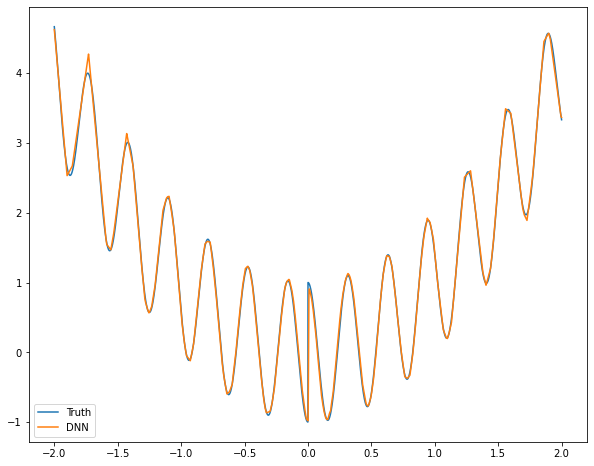

In [48]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

### Double Amount of Layers 64 Nodes

In [55]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 64
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 64)                128       
                                                                 
 dense_58 (Dense)            (None, 64)                4160      
                                                                 
 dense_59 (Dense)            (None, 64)                4160      
                                                                 
 dense_60 (Dense)            (None, 64)                4160      
                                                                 
 dense_61 (Dense)            (None, 64)                4160      
                                                                 
 dense_62 (Dense)            (None, 64)                4160      
                                                                 
 dense_63 (Dense)            (None, 64)              

40/40 [==============================] - 0s 3ms/step - loss: 0.1903 - accuracy: 0.0000e+00
Epoch 64/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1717 - accuracy: 0.0000e+00
Epoch 65/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1952 - accuracy: 0.0000e+00
Epoch 66/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1706 - accuracy: 0.0000e+00
Epoch 67/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1731 - accuracy: 0.0000e+00
Epoch 68/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.0000e+00
Epoch 69/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1601 - accuracy: 0.0000e+00
Epoch 70/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.1544 - accuracy: 0.0000e+00
Epoch 71/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1561 - accuracy: 0.0000e+00
Epoch 72/1000
40/40 [==============================] - 0s 3ms/step - 

40/40 [==============================] - 0s 3ms/step - loss: 0.0329 - accuracy: 0.0000e+00
Epoch 141/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.0000e+00
Epoch 142/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.0000e+00
Epoch 143/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.0000e+00
Epoch 144/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0302 - accuracy: 0.0000e+00
Epoch 145/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.0000e+00
Epoch 146/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.0000e+00
Epoch 147/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.0000e+00
Epoch 148/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.0000e+00
Epoch 149/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.0000e+00
Epoch 218/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0133 - accuracy: 0.0000e+00
Epoch 219/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch 220/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.0075 - accuracy: 0.0000e+00
Epoch 221/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.0000e+00
Epoch 222/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0054 - accuracy: 0.0000e+00
Epoch 223/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.0133 - accuracy: 0.0000e+00
Epoch 224/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 0.0000e+00
Epoch 225/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0095 - accuracy: 0.0000e+00
Epoch 226/1000
40/40 [==============================] - 0s 

40/40 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.0000e+00
Epoch 295/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 0.0000e+00
Epoch 296/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0103 - accuracy: 0.0000e+00
Epoch 297/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.0000e+00
Epoch 298/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy: 0.0000e+00
Epoch 299/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0045 - accuracy: 0.0000e+00
Epoch 300/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 301/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 302/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0061 - accuracy: 0.0000e+00
Epoch 303/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.0000e+00
Epoch 372/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 0.0000e+00
Epoch 373/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 374/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0189 - accuracy: 0.0000e+00
Epoch 375/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 376/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 0.0000e+00
Epoch 377/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 378/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 379/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 380/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 0.0077 - accuracy: 0.0000e+00
Epoch 449/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.0000e+00
Epoch 450/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 0.0000e+00
Epoch 451/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 0.0000e+00
Epoch 452/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.0000e+00
Epoch 453/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00
Epoch 454/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 455/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.0000e+00
Epoch 456/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 0.0000e+00
Epoch 457/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.0000e+00
Epoch 526/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.0000e+00
Epoch 527/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 528/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0047 - accuracy: 0.0000e+00
Epoch 529/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.0000e+00
Epoch 530/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 531/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 0.0000e+00
Epoch 532/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 533/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 534/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 0.0078 - accuracy: 0.0000e+00
Epoch 603/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 0.0000e+00
Epoch 604/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.0000e+00
Epoch 605/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 606/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 607/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 0.0000e+00
Epoch 608/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.0000e+00
Epoch 609/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0109 - accuracy: 0.0000e+00
Epoch 610/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 611/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 4ms/step - loss: 0.0086 - accuracy: 0.0000e+00
Epoch 680/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 0.0000e+00
Epoch 681/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 682/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0075 - accuracy: 0.0000e+00
Epoch 683/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 684/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.0000e+00
Epoch 685/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 0.0000e+00
Epoch 686/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 687/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 688/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.0000e+00
Epoch 757/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.0000e+00
Epoch 758/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0079 - accuracy: 0.0000e+00
Epoch 759/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00
Epoch 760/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 761/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 762/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 763/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 764/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 765/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 834/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.0000e+00
Epoch 835/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 836/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0043 - accuracy: 0.0000e+00
Epoch 837/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy: 0.0000e+00
Epoch 838/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 839/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 840/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0074 - accuracy: 0.0000e+00
Epoch 841/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 842/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 0.0000e+00
Epoch 911/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0077 - accuracy: 0.0000e+00
Epoch 912/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.0081 - accuracy: 0.0000e+00
Epoch 913/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 914/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 0.0000e+00
Epoch 915/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 916/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 917/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0057 - accuracy: 0.0000e+00
Epoch 918/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 919/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 988/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 989/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.0000e+00
Epoch 990/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 991/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 992/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.0000e+00
Epoch 993/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 994/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 995/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 996/1000
40/40 [==============================] - 0s 3m

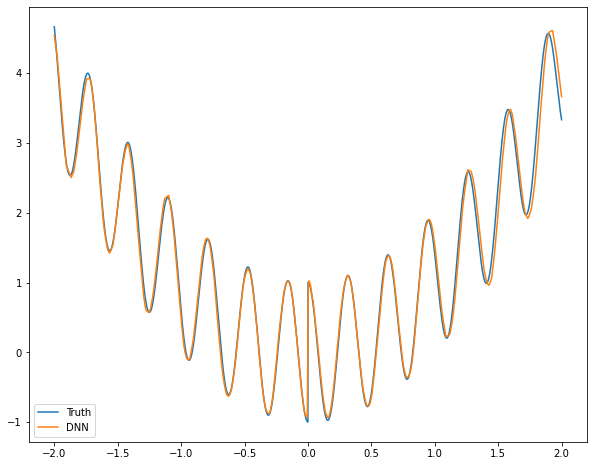

In [56]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

## Problem 4
Using the best setup from the previous problem, train a model using the noisy data.

In [51]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 64
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, y, epochs=1000, batch_size=128, verbose=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                128       
                                                                 
 dense_49 (Dense)            (None, 64)                4160      
                                                                 
 dense_50 (Dense)            (None, 64)                4160      
                                                                 
 dense_51 (Dense)            (None, 64)                4160      
                                                                 
 dense_52 (Dense)            (None, 64)                4160      
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dense_54 (Dense)            (None, 64)              

40/40 [==============================] - 0s 3ms/step - loss: 1.2879 - accuracy: 0.0000e+00
Epoch 64/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2868 - accuracy: 0.0000e+00
Epoch 65/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.3189 - accuracy: 0.0000e+00
Epoch 66/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.3522 - accuracy: 0.0000e+00
Epoch 67/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.3086 - accuracy: 0.0000e+00
Epoch 68/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2769 - accuracy: 0.0000e+00
Epoch 69/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2768 - accuracy: 0.0000e+00
Epoch 70/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.3189 - accuracy: 0.0000e+00
Epoch 71/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2765 - accuracy: 0.0000e+00
Epoch 72/1000
40/40 [==============================] - 0s 3ms/step - 

40/40 [==============================] - 0s 3ms/step - loss: 1.2252 - accuracy: 0.0000e+00
Epoch 141/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.2644 - accuracy: 0.0000e+00
Epoch 142/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2464 - accuracy: 0.0000e+00
Epoch 143/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2287 - accuracy: 0.0000e+00
Epoch 144/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2075 - accuracy: 0.0000e+00
Epoch 145/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2317 - accuracy: 0.0000e+00
Epoch 146/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2238 - accuracy: 0.0000e+00
Epoch 147/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2628 - accuracy: 0.0000e+00
Epoch 148/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2375 - accuracy: 0.0000e+00
Epoch 149/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 1.2054 - accuracy: 0.0000e+00
Epoch 218/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2150 - accuracy: 0.0000e+00
Epoch 219/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1985 - accuracy: 0.0000e+00
Epoch 220/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1967 - accuracy: 0.0000e+00
Epoch 221/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2056 - accuracy: 0.0000e+00
Epoch 222/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2095 - accuracy: 0.0000e+00
Epoch 223/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2051 - accuracy: 0.0000e+00
Epoch 224/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2032 - accuracy: 0.0000e+00
Epoch 225/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2104 - accuracy: 0.0000e+00
Epoch 226/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 1.1760 - accuracy: 0.0000e+00
Epoch 295/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1612 - accuracy: 0.0000e+00
Epoch 296/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1747 - accuracy: 0.0000e+00
Epoch 297/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1673 - accuracy: 0.0000e+00
Epoch 298/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1802 - accuracy: 0.0000e+00
Epoch 299/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.3451 - accuracy: 0.0000e+00
Epoch 300/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2272 - accuracy: 0.0000e+00
Epoch 301/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2337 - accuracy: 0.0000e+00
Epoch 302/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2156 - accuracy: 0.0000e+00
Epoch 303/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 7ms/step - loss: 1.1897 - accuracy: 0.0000e+00
Epoch 372/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1692 - accuracy: 0.0000e+00
Epoch 373/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1949 - accuracy: 0.0000e+00
Epoch 374/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1579 - accuracy: 0.0000e+00
Epoch 375/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1771 - accuracy: 0.0000e+00
Epoch 376/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1532 - accuracy: 0.0000e+00
Epoch 377/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1550 - accuracy: 0.0000e+00
Epoch 378/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1386 - accuracy: 0.0000e+00
Epoch 379/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1496 - accuracy: 0.0000e+00
Epoch 380/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 5ms/step - loss: 1.1538 - accuracy: 0.0000e+00
Epoch 449/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1345 - accuracy: 0.0000e+00
Epoch 450/1000
40/40 [==============================] - 0s 5ms/step - loss: 1.1600 - accuracy: 0.0000e+00
Epoch 451/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1696 - accuracy: 0.0000e+00
Epoch 452/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1933 - accuracy: 0.0000e+00
Epoch 453/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1526 - accuracy: 0.0000e+00
Epoch 454/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1439 - accuracy: 0.0000e+00
Epoch 455/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1537 - accuracy: 0.0000e+00
Epoch 456/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1333 - accuracy: 0.0000e+00
Epoch 457/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 1.1210 - accuracy: 0.0000e+00
Epoch 526/1000
40/40 [==============================] - 0s 5ms/step - loss: 1.1141 - accuracy: 0.0000e+00
Epoch 527/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1201 - accuracy: 0.0000e+00
Epoch 528/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1351 - accuracy: 0.0000e+00
Epoch 529/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1403 - accuracy: 0.0000e+00
Epoch 530/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.2063 - accuracy: 0.0000e+00
Epoch 531/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1329 - accuracy: 0.0000e+00
Epoch 532/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1508 - accuracy: 0.0000e+00
Epoch 533/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1207 - accuracy: 0.0000e+00
Epoch 534/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 1.0929 - accuracy: 0.0000e+00
Epoch 603/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1139 - accuracy: 0.0000e+00
Epoch 604/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1442 - accuracy: 0.0000e+00
Epoch 605/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1205 - accuracy: 0.0000e+00
Epoch 606/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1100 - accuracy: 0.0000e+00
Epoch 607/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0950 - accuracy: 0.0000e+00
Epoch 608/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1023 - accuracy: 0.0000e+00
Epoch 609/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.1285 - accuracy: 0.0000e+00
Epoch 610/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.1154 - accuracy: 0.0000e+00
Epoch 611/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 0.0000e+00
Epoch 680/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0545 - accuracy: 0.0000e+00
Epoch 681/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0835 - accuracy: 0.0000e+00
Epoch 682/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0494 - accuracy: 0.0000e+00
Epoch 683/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0826 - accuracy: 0.0000e+00
Epoch 684/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0530 - accuracy: 0.0000e+00
Epoch 685/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0838 - accuracy: 0.0000e+00
Epoch 686/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0847 - accuracy: 0.0000e+00
Epoch 687/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0624 - accuracy: 0.0000e+00
Epoch 688/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 0.0000e+00
Epoch 757/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0433 - accuracy: 0.0000e+00
Epoch 758/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0522 - accuracy: 0.0000e+00
Epoch 759/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0457 - accuracy: 0.0000e+00
Epoch 760/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0591 - accuracy: 0.0000e+00
Epoch 761/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0582 - accuracy: 0.0000e+00
Epoch 762/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0573 - accuracy: 0.0000e+00
Epoch 763/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0926 - accuracy: 0.0000e+00
Epoch 764/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0864 - accuracy: 0.0000e+00
Epoch 765/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 4ms/step - loss: 1.0651 - accuracy: 0.0000e+00
Epoch 834/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0439 - accuracy: 0.0000e+00
Epoch 835/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0566 - accuracy: 0.0000e+00
Epoch 836/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0253 - accuracy: 0.0000e+00
Epoch 837/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0460 - accuracy: 0.0000e+00
Epoch 838/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0360 - accuracy: 0.0000e+00
Epoch 839/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0296 - accuracy: 0.0000e+00
Epoch 840/1000
40/40 [==============================] - 0s 5ms/step - loss: 1.0249 - accuracy: 0.0000e+00
Epoch 841/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0386 - accuracy: 0.0000e+00
Epoch 842/1000
40/40 [==============================] - 0s 3m

40/40 [==============================] - 0s 3ms/step - loss: 1.0178 - accuracy: 0.0000e+00
Epoch 911/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0314 - accuracy: 0.0000e+00
Epoch 912/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0172 - accuracy: 0.0000e+00
Epoch 913/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0942 - accuracy: 0.0000e+00
Epoch 914/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0393 - accuracy: 0.0000e+00
Epoch 915/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0479 - accuracy: 0.0000e+00
Epoch 916/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0137 - accuracy: 0.0000e+00
Epoch 917/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0308 - accuracy: 0.0000e+00
Epoch 918/1000
40/40 [==============================] - 0s 4ms/step - loss: 1.0280 - accuracy: 0.0000e+00
Epoch 919/1000
40/40 [==============================] - 0s 4m

40/40 [==============================] - 0s 3ms/step - loss: 1.0419 - accuracy: 0.0000e+00
Epoch 988/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0330 - accuracy: 0.0000e+00
Epoch 989/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0530 - accuracy: 0.0000e+00
Epoch 990/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0315 - accuracy: 0.0000e+00
Epoch 991/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0348 - accuracy: 0.0000e+00
Epoch 992/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0527 - accuracy: 0.0000e+00
Epoch 993/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0211 - accuracy: 0.0000e+00
Epoch 994/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0280 - accuracy: 0.0000e+00
Epoch 995/1000
40/40 [==============================] - 0s 3ms/step - loss: 1.0503 - accuracy: 0.0000e+00
Epoch 996/1000
40/40 [==============================] - 0s 3m

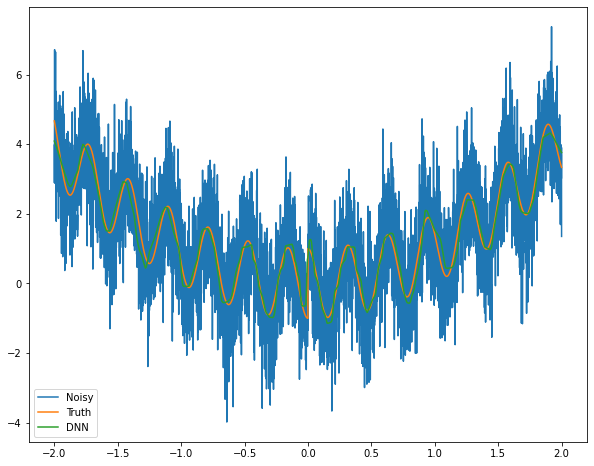

In [54]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,y,label="Noisy")
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()